In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import networkx as nx
import community.community_louvain as cl
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import copy
import pickle

import time
from tqdm import tqdm

# preprocessed dataset of wheat trading from 2006 to 2021

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Data/comtradedata/df_2006_2021_1001.csv")
df.head()

,Unnamed: 0,Year,From,To,Trade Value (US$)
0,0,2006,Algeria,Egypt,5452264
1,1,2006,Andorra,Lebanon,1
2,2,2006,"Areas, nes",Aruba,14580
3,3,2006,"Areas, nes",Côte d'Ivoire,339
4,4,2006,"Areas, nes",Ireland,1575677


In [ ]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,Year,From,To,Trade Value (US$)
0,2006,Algeria,Egypt,5452264
1,2006,Andorra,Lebanon,1
2,2006,"Areas, nes",Aruba,14580
3,2006,"Areas, nes",Côte d'Ivoire,339
4,2006,"Areas, nes",Ireland,1575677


# changes in 2022

2022년으로 넘어오면서 러시아와 우크라이나는 지속된 전쟁으로 인해 밀의 경우 수출입 경로가 중국 혹은 북한과 같은 국가를 제외하고는 사실상 차단되었기 때문에 노드를 삭제하는 판단을 하였고, 기존의 주요 수출국들 중에서 부담을 느껴 수출 중단을 선언한 인도와 같은 국가의 경우 인도에서 출발하는 데이터셋의 From에 해당하는 값이 인도인 행의 데이터를 삭제하여 네트워크를 만들어보면 조치를 취하기 이전에 변화한 상황에 대한 인식이 가능해 질 것이고, 추후 어느 국가가 주요 어려움을 겪을 지 등에 대해 판단해볼 수 있을 것이다.

## 2022 new dataset

In [ ]:
wheat2021 = df[df['Year'] == 2021].copy()
wheat2021

,Year,From,To,Trade Value (US$)
29279,2021,Algeria,Hungary,7
29280,2021,Algeria,Switzerland,646
29281,2021,Algeria,USA,11315
29282,2021,Algeria,United Kingdom,1622
29283,2021,Angola,Netherlands,117
...,...,...,...,...
30827,2021,Uzbekistan,Tajikistan,5794570
30828,2021,Viet Nam,Netherlands,138
30829,2021,Viet Nam,Switzerland,2194
30830,2021,Zambia,United Rep. of Tanzania,188674


In [ ]:
df2022 = wheat2021.loc[(wheat2021['From'] != 'Russian Federation') & (wheat2021['From'] != 'Ukraine') & (wheat2021['From'] != 'India')
                                & (wheat2021['To'] != 'Russian Federation') & (wheat2021['To'] != 'Ukraine')]

In [ ]:
print(df2022[df2022['From'] == 'Russian Federation'])
print(df2022[df2022['From'] == 'Ukraine'])
print(df2022[df2022['From'] == 'India'])
print(df2022[df2022['To'] == 'Russian Federation'])
print(df2022[df2022['To'] == 'Ukraine'], '\n')

print(df2022[df2022['To'] == 'India'])
df2022

Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: [] 

       Year            From     To  Trade Value (US$)
29316  2021       Australia  India              22629
30143  2021          Mexico  India                423
30579  2021          Turkey  India               1801
30654  2021             USA  India                 43
30794  2021  United Kingdom  India               1745


,Year,From,To,Trade Value (US$)
29279,2021,Algeria,Hungary,7
29280,2021,Algeria,Switzerland,646
29281,2021,Algeria,USA,11315
29282,2021,Algeria,United Kingdom,1622
29283,2021,Angola,Netherlands,117
...,...,...,...,...
30827,2021,Uzbekistan,Tajikistan,5794570
30828,2021,Viet Nam,Netherlands,138
30829,2021,Viet Nam,Switzerland,2194
30830,2021,Zambia,United Rep. of Tanzania,188674


## 2022 graph making

In [ ]:
wheat_2022preview = nx.from_pandas_edgelist(df2022, source='From', target='To', 
                                                 edge_attr='Trade Value (US$)', create_using=nx.DiGraph()) # Directed Graph

In [ ]:
# # 저장
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/wheat_2022preview.pkl', 'wb') as f:
#   pickle.dump(wheat_2022preview, f)

In [ ]:
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/wheat_2022preview.pkl', 'rb') as f:
#   wheat_2022preview = pickle.load(f)

In [ ]:
# finding independent, moderate, dependent node in Graph
def nodeProportion(G):
  sum_ratio = 0
  all_ratio = {}
  high_nodes = []
  other_nodes = []
  for node in list(G.nodes()):
      sum_ratio += G.out_degree(node, weight='Trade Value (US$)')

  for node in list(G.nodes()):
      ratio = (G.out_degree(node, weight='Trade Value (US$)') / sum_ratio) * 100
      all_ratio[node] =  ratio

  # 세계 수출의 5% 이상을 차지하는 노드 파악
  for node in list(G.nodes()):
    high_nodes.append(node) if all_ratio[node] > 1 else other_nodes.append(node)

  return high_nodes, other_nodes

In [ ]:
def DiGraphPlot_all(G, year):
    fig, ax = plt.subplots()
    fig.set_size_inches((64, 64))
    
    plt.rcParams.update({
        "figure.facecolor":  (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
        "savefig.facecolor": (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
    })

    # nodelist by dependency
    high_nodes, other_nodes = nodeProportion(G)
    
    ## layout 설정
    layout = {"circular layout of Countries in {}".format(year) : nx.circular_layout(G)}
              
    for _, item in enumerate(layout.items()):
        title, pos = item[0], item[1]
        nx.draw_networkx(G, pos=pos, font_color="white", ax=ax, font_size=8)
        
        # 수입 의존도가 낮은 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = high_nodes,
                               node_color="tab:blue",
                               node_size = 5000)        
        
        # 나머지 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = other_nodes,
                               node_color="black",
                               node_size = 5000)
        
        # arrow style 지정
        nx.draw_networkx_edges(G, pos, edge_color='k', arrowsize=15, connectionstyle='arc3', min_target_margin=30)

        
        ax.set_title(title, fontsize=40)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/worldIMG/worldGraph_in_{year}.png",
                # dpi = 200, # 해상도
                bbox_inches='tight' # 
                )
    plt.show()
    plt.close()

In [ ]:
# saving plot image
DiGraphPlot_all(wheat_2022preview, 2022)

# Louvain community analysis (2022)


In [ ]:
wheat_2022preview

## Sub Group to Images

Louvain 알고리즘에 따라 주어진 네트워크를 군집화해본다.

In [ ]:
!pip install python-louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def Louvain(G):

    Graph = nx.to_undirected(G)
    partition = cl.best_partition(Graph, random_state=2022)

    ct = 1
    p_list = [ [] for i in range(10)]
    
    
    for country, i in partition.items():
        p_list[i].append(country)

    # for lst in p_list:
      # if lst == []:
        # break
      # else:
        # print(f"{ct}번째 그룹 : ", lst)
        # part_group['group{}'.format(ct)] = lst
        ct += 1
    
    # part_group = {v:k for k,v in part_group.items()}
    
    return Graph, partition

def Louvain_Plot(Graph, partition, year) :
    
    pos = nx.kamada_kawai_layout(Graph, scale=10)
    cmap = cm.get_cmap('plasma', max(partition.values()) + 1)

    edges = Graph.edges()
    weights = np.array([Graph[u][v]['Trade Value (US$)'] for u, v in edges])    
    sizes = np.array(list(dict(Graph.out_degree(weight='Trade Value (US$)')).values())) + 1

    """ Visualization """
    plt.figure(figsize=(20,16))
    im = nx.draw_networkx_nodes(Graph, pos, partition.keys(), node_size=np.power(sizes, 1/4),
                        cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(Graph, pos, width=np.sqrt(weights)/1e4, alpha=0.4)
    nx.draw_networkx_labels(Graph, pos, font_size=8, font_color="white", bbox={'facecolor':'black','edgecolor':'black','boxstyle':'round','alpha':0.5})
    plt.colorbar(im)
    plt.title('Graph of {}'.format(year))
    # plt.show()
    plt.savefig("/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/clusterIMG/{}_louvain_img.png".format(year),
                # dpi = 200, # 해상도
                bbox_inches='tight' # 
                )


2022년에 대해 진행해보고자 한다.

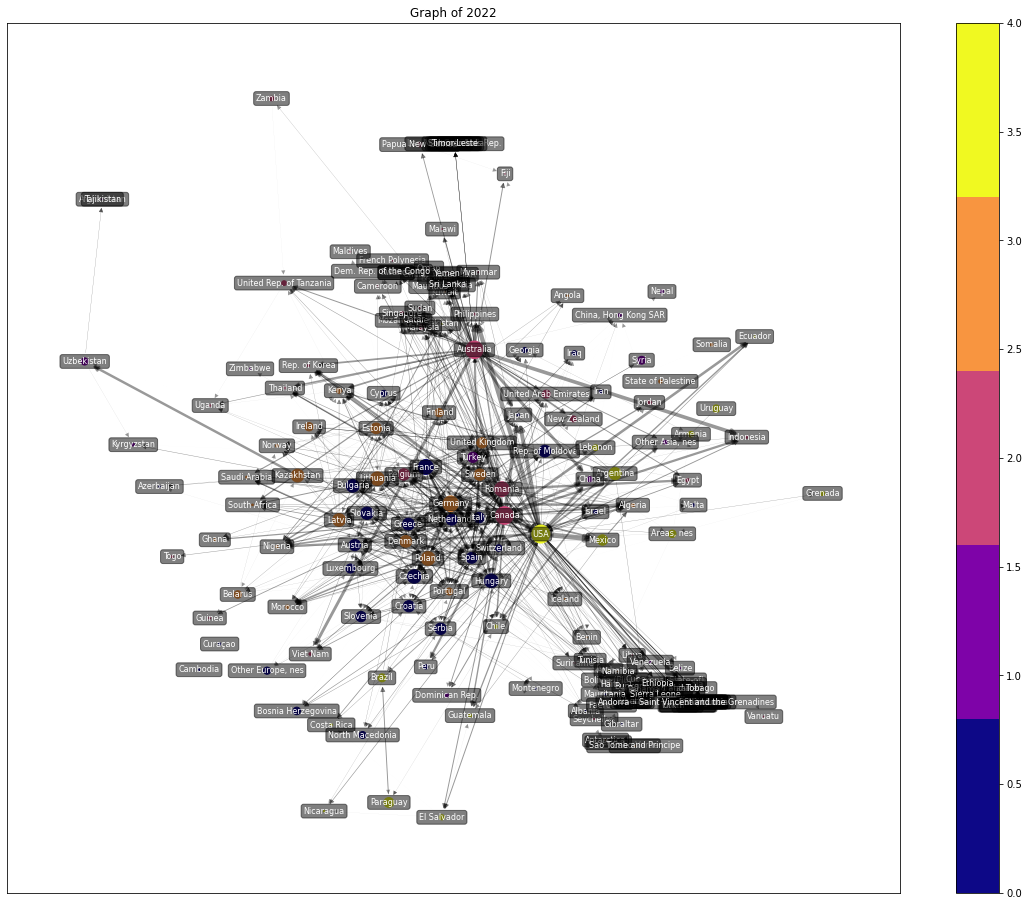

In [ ]:
year = 2022


G, partition = Louvain(wheat_2022preview)

Louvain_Plot(wheat_2022preview, partition, year)


In [ ]:
len(G.nodes())

180

In [ ]:
partition.values()

dict_values([3, 0, 0, 4, 3, 3, 0, 4, 4, 4, 0, 0, 4, 4, 2, 4, 4, 0, 3, 4, 3, 0, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 3, 2, 1, 2, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 2, 0, 0, 0, 3, 1, 3, 3, 0, 2, 2, 0, 2, 3, 3, 2, 3, 3, 2, 2, 0, 4, 4, 0, 1, 2, 4, 4, 3, 2, 1, 4, 2, 3, 4, 2, 3, 0, 2, 2, 3, 2, 2, 4, 3, 4, 0, 4, 2, 2, 4, 0, 2, 1, 1, 3, 0, 0, 0, 0, 0, 3, 3, 3, 4, 1, 3, 3, 3, 3, 0, 0, 4, 4, 1, 0, 1, 2, 3, 3, 3, 2, 3, 0, 0, 3, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1])

## Making Sub Group Dataset

In [ ]:
partial_groups_2022= {}
i = 0
while True:
  if i in partition.values():
    partial_groups_2022[str(i)] = [k for k, v in partition.items() if v == i]
    i += 1
  else:
    print("{}년의 그룹 수 :".format(year) +str(i))
    partial_groups_2022['group_number'] = i
    break

2022년의 그룹 수 :5


In [ ]:
print(type(partial_groups_2022['group_number']))

subgroup_wheat_2022 = {}

for group in range(partial_groups_2022['group_number']):
  print(partial_groups_2022[str(group)])
  print(group)
  subgroup_wheat_2022[str(group)] = partial_groups_2022[str(group)]

<class 'int'>
['Hungary', 'Switzerland', 'Netherlands', 'Croatia', 'Rep. of Moldova', 'Italy', 'Spain', 'Georgia', 'Japan', 'Austria', 'Azerbaijan', 'Cyprus', 'Czechia', 'Greece', 'Luxembourg', 'Montenegro', 'Serbia', 'Slovakia', 'Slovenia', 'Bulgaria', 'France', 'Bosnia Herzegovina', 'Cambodia', 'Israel', 'Peru', 'Tunisia', 'Albania', 'Iran', 'North Macedonia', 'Curaçao', 'Other Europe, nes', 'Iraq', 'Malta', 'Mauritania', 'Andorra', 'Gibraltar']
0
['China', 'China, Hong Kong SAR', 'China, Macao SAR', 'India', 'Other Asia, nes', 'Turkey', 'Belize', 'Dominican Rep.', 'Venezuela', 'Zimbabwe', 'Uzbekistan', 'Kyrgyzstan', 'Nepal', 'Syria', 'Sierra Leone', 'Afghanistan', 'Tajikistan']
1
['Canada', 'United Rep. of Tanzania', 'Belgium', 'Australia', 'Bahrain', 'Bangladesh', 'Burundi', 'Egypt', 'Fiji', 'French Polynesia', 'Indonesia', "Lao People's Dem. Rep.", 'Madagascar', 'Malawi', 'Malaysia', 'Mauritius', 'Myanmar', 'New Caledonia', 'New Zealand', 'Oman', 'Papua New Guinea', 'Philippines',

In [ ]:
tmp_df = {} # temporary usage

# 나눠진 그룹 수
max_iter = 5 # partial_groups_2022['group_number']

sub_group_wheat_2022 = {}

true_idx = {}

# for every ith group
for i in range(max_iter):
  # idx를 받아올 DataFrame 지정
  tmp_df[str(i)] = df2022.copy()
  
  # From과 To가 모두 group list에 있는 국가인 index를 담는 리스트
  true_idx[i] = []

  # read DataFrame for every idx, row
  for idx, row in tmp_df[str(i)].iterrows():

    # boolean of presence
    in_From = row['From'] in partial_groups_2022[str(i)]
    in_To   = row['To'] in partial_groups_2022[str(i)]
    
    # condition
    if (in_From == True) and (in_To == True):
      true_idx[i].append(idx)
  
  sub_group_wheat_2022[str(i)] = copy.deepcopy(tmp_df[str(i)].loc[true_idx[i],:])


In [ ]:
sub_group_wheat_2022['0']

,Year,From,To,Trade Value (US$)
29356,2021,Austria,Azerbaijan,221549
29360,2021,Austria,Croatia,3978611
29361,2021,Austria,Cyprus,5436326
29362,2021,Austria,Czechia,1275157
29364,2021,Austria,Georgia,49530
...,...,...,...,...
30537,2021,Switzerland,Japan,7
30539,2021,Switzerland,Netherlands,14
30541,2021,Switzerland,Slovakia,106
30542,2021,Switzerland,Slovenia,2444


In [ ]:
subgroup_wheat_2022['1']

['China',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'India',
 'Other Asia, nes',
 'Turkey',
 'Belize',
 'Dominican Rep.',
 'Venezuela',
 'Zimbabwe',
 'Uzbekistan',
 'Kyrgyzstan',
 'Nepal',
 'Syria',
 'Sierra Leone',
 'Afghanistan',
 'Tajikistan']

## sub_group_wheat to pickle

In [ ]:
# # 각 Cluster별 데이터를 담고 있는 sub_group_wheat 객체를 저장 : memorize 목적
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/subgroup_wheat_2022.pkl', 'wb') as f:
#   pickle.dump(subgroup_wheat_2022, f)

In [ ]:
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/partial_groups_2022.pkl', 'wb') as f:
#   pickle.dump(partial_groups_2022, f)

## Sub Group Dataset 불러오기

### subgroup_wheat_2022

In [ ]:
# # louvain algorithm으로 partition한 cluster dataset "sub_group_wheat"를 불러옴
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/subgroup_wheat_2022.pkl', 'rb') as f:
#   subgroup_wheat_2022 = pickle.load(f)

In [ ]:
type(subgroup_wheat_2022)

dict

### partial_groups

In [ ]:
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/partial_groups_2022.pkl', 'rb') as f:
#   partial_groups_2022 = pickle.load(f)

In [ ]:
type(partial_groups_2022)

dict

In [ ]:
partial_groups_2022 # 나누어진 그룹과 그룹수를 담는 dictionary

{'0': ['Hungary',
  'Switzerland',
  'Netherlands',
  'Croatia',
  'Rep. of Moldova',
  'Italy',
  'Spain',
  'Georgia',
  'Japan',
  'Austria',
  'Azerbaijan',
  'Cyprus',
  'Czechia',
  'Greece',
  'Luxembourg',
  'Montenegro',
  'Serbia',
  'Slovakia',
  'Slovenia',
  'Bulgaria',
  'France',
  'Bosnia Herzegovina',
  'Cambodia',
  'Israel',
  'Peru',
  'Tunisia',
  'Albania',
  'Iran',
  'North Macedonia',
  'Curaçao',
  'Other Europe, nes',
  'Iraq',
  'Malta',
  'Mauritania',
  'Andorra',
  'Gibraltar'],
 '1': ['China',
  'China, Hong Kong SAR',
  'China, Macao SAR',
  'India',
  'Other Asia, nes',
  'Turkey',
  'Belize',
  'Dominican Rep.',
  'Venezuela',
  'Zimbabwe',
  'Uzbekistan',
  'Kyrgyzstan',
  'Nepal',
  'Syria',
  'Sierra Leone',
  'Afghanistan',
  'Tajikistan'],
 '2': ['Canada',
  'United Rep. of Tanzania',
  'Belgium',
  'Australia',
  'Bahrain',
  'Bangladesh',
  'Burundi',
  'Egypt',
  'Fiji',
  'French Polynesia',
  'Indonesia',
  "Lao People's Dem. Rep.",
  'Madag

In [ ]:
partial_groups_2022['group_number'] # 총 그룹 수

5

### wheat_2022preview (그래프)

In [ ]:
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/wheat_2022preview.pkl', 'rb') as f:
#   pickle.dump(wheat_2022preview, f)

In [ ]:
wheat_2022preview

## Graph making (Sub Groups)

In [ ]:
max_iter = partial_groups_2022['group_number']

In [ ]:
subgroup_wheat_2022

In [ ]:
# Dataset     : sub_group_wheat_2022['group_number']
# Graph       : subGraph_2022['group_number']
# # of Groups : max_iter

year = 2022

subGraph_2022 = {}

for number in range(max_iter):
  # making graph
  subGraph_2022[str(number)] = nx.from_pandas_edgelist(sub_group_wheat_2022[str(number)], source='From', target='To',
                                                       edge_attr='Trade Value (US$)', create_using=nx.DiGraph()) # Directed Graph

  print(f'SubGraph {number} of {year} : {nx.info(subGraph_2022[str(number)])}')

SubGraph 0 of 2022 : DiGraph with 36 nodes and 259 edges
SubGraph 1 of 2022 : DiGraph with 17 nodes and 20 edges
SubGraph 2 of 2022 : DiGraph with 56 nodes and 120 edges
SubGraph 3 of 2022 : DiGraph with 40 nodes and 193 edges
SubGraph 4 of 2022 : DiGraph with 31 nodes and 58 edges


# Sub Group Outdegree, Indegree

## Outdegree

weight를 부여한 실질적 영향력을 확인한다. 

In [ ]:
# subGraph_2022['group_number'].out_degree(weight=1)
# subGraph_2022['group_number'].out_degree(weight='Trade Value (US$)')
# ex) subGraph_2022['0'].out_degree # dictionary with {'Country': # of out_degree}

# dictionary that contains all countires
all_countries = {}
sub_total_trade_values = {}
dependent_countries = {}
non_dependent_countries = {}

for number in range(max_iter):
  all_countries[str(number)] = list(subGraph_2022[str(number)].nodes)
  sub_total_trade_values[str(number)] = sub_group_wheat_2022[str(number)]['Trade Value (US$)'].sum()
  # 군집 내 총 수출량의 10% 미만
  dependent_countries[str(number)] = [
  country for country, out_degrees in subGraph_2022[str(number)].out_degree(weight='Trade Value (US$)') if out_degrees <= sub_total_trade_values[str(number)]/10                            
  ]
  non_dependent_countries[str(number)] = [item for item in all_countries[str(number)] if item not in dependent_countries[str(number)]]


In [ ]:
# 군집 내 수출량이 많은 국가들 
def powerfulSuppliers(year):
  iter = 0
  while True:
    if iter == max_iter:
      break
    print("{}년 {}번 그룹의 밀 주요 공급국 : ".format(year, iter), non_dependent_countries[str(iter)], '\n')
    iter +=1 

In [ ]:
# test
powerfulSuppliers(2022)

2022년 0번 그룹의 밀 주요 공급국 :  ['Hungary', 'France'] 

2022년 1번 그룹의 밀 주요 공급국 :  ['Syria', 'Turkey', 'Uzbekistan'] 

2022년 2번 그룹의 밀 주요 공급국 :  ['Australia', 'Romania', 'Canada'] 

2022년 3번 그룹의 밀 주요 공급국 :  ['Lithuania', 'Poland', 'Germany', 'Latvia'] 

2022년 4번 그룹의 밀 주요 공급국 :  ['USA'] 



### Rep. of Korea 확인

In [ ]:
tmp_iter = max_iter

for iter in range(tmp_iter):

  if 'Rep. of Korea' in list(subGraph_2022[str(iter)].nodes):
    print(f"\n In {year}, Rep. of Korea is in Group {iter}")



 In 2022, Rep. of Korea is in Group 2


2022년 한국이 속한 그룹의 국가들을 확인

In [ ]:
kor2022 = set(list(subGraph_2022['2'].nodes))

In [ ]:
kor2022

{'Australia',
 'Bahrain',
 'Bangladesh',
 'Belgium',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Canada',
 "Côte d'Ivoire",
 'Dem. Rep. of the Congo',
 'Egypt',
 'Ethiopia',
 'Fiji',
 'French Polynesia',
 'Gabon',
 'Guinea',
 'Guyana',
 'Indonesia',
 'Jamaica',
 'Jordan',
 "Lao People's Dem. Rep.",
 'Libya',
 'Madagascar',
 'Malawi',
 'Malaysia',
 'Maldives',
 'Mali',
 'Mauritius',
 'Myanmar',
 'New Caledonia',
 'New Zealand',
 'Oman',
 'Papua New Guinea',
 'Philippines',
 'Qatar',
 'Rep. of Korea',
 'Romania',
 'Rwanda',
 'Senegal',
 'Seychelles',
 'Singapore',
 'Solomon Isds',
 'Sri Lanka',
 'Sudan',
 'Suriname',
 'Thailand',
 'Timor-Leste',
 'Togo',
 'Turkmenistan',
 'Uganda',
 'United Arab Emirates',
 'United Rep. of Tanzania',
 'Vanuatu',
 'Viet Nam',
 'Yemen',
 'Zambia'}

================================

## Sub Group Centrality analysis

### return_centralities_as_dict()

In [ ]:
from networkx.algorithms.centrality.eigenvector import eigenvector_centrality
# https://frhyme.github.io/python-lib/network-centrality/#closeness-centrality 참고

def return_centralities_as_dict(input_g):
    # weighted degree centrality를 딕셔너리로 리턴
    def return_weighted_degree_centrality(input_g, normalized=False):
        w_d_centrality = {n:0.0 for n in input_g.nodes()} # initialize
        for u, v, d in input_g.edges(data=True):
            w_d_centrality[u]+=d['Trade Value (US$)']
            w_d_centrality[v]+=d['Trade Value (US$)']
        if normalized==True:
            weighted_sum = sum(w_d_centrality.values())
            return {k:v/weighted_sum for k, v in w_d_centrality.items()}
        else:
            return w_d_centrality

    def return_eigenvector_centrality(input_g):
        return nx.eigenvector_centrality(input_g, weight='Trade Value (US$)', max_iter=1000000000000) 
        # max_iter는 default 100으로 설정되어 미지정시 PowerIterationFailedConvergence 에러가 발생

    return {
        'weighted_deg':return_weighted_degree_centrality(input_g),
        'eigenvector_cent':return_eigenvector_centrality(input_g)
    }

In [ ]:
# # 계산 시 약 1.5h 소요
# cenInfo_2022 = {}
    
# for number in tqdm(range(max_iter), desc="{}년도의 Sub Group centrality 계산".format(year), mininterval=0.01):
#   cenInfo_2022[str(number)] = {}
  
#   cenInfo_2022[str(number)]['wdeg'] = return_centralities_as_dict(subGraph_2022[str(number)])['weighted_deg']
  
#   cenInfo_2022[str(number)]['weig'] = return_centralities_as_dict(subGraph_2022[str(number)])['eigenvector_cent']
  

2022년도의 Sub Group centrality 계산: 100%|██████████| 5/5 [1:59:32<00:00, 1434.45s/it]


## subgroup_cenInfo.pkl 로 저장하기

In [ ]:
# # saving
# with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/subgroup_cenInfo_2022.pkl', 'wb') as f:
#   pickle.dump(cenInfo_2022, f)

In [ ]:
with open('/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/pickles/subgroup_cenInfo_2022.pkl', 'rb') as f:
  subgroup_cenInfo_2022 = pickle.load(f)

# Sub Group Plotting

나누어진 각 클러스터들의 네트워크 관계를 시각화하고 이미지로 저장해보았다.

In [ ]:
# finding independent, moderate, dependent node in Graph
def nodeDependency(G):
  indep_nodes = []
  moderate_nodes = []
  dep_nodes = []
  for node in list(G.nodes()):
      ratio = G.out_degree(node, weight='Trade Value (US$)') / (G.out_degree(node, weight='Trade Value (US$)') + G.in_degree(node, weight='Trade Value (US$)'))
      dep_nodes.append(node) if ratio < 0.3 else indep_nodes.append(node) if ratio > 0.7 else moderate_nodes.append(node)

  return indep_nodes, moderate_nodes, dep_nodes

In [ ]:

def DiGraphPlot(G, year, number):
    fig, ax = plt.subplots()
    fig.set_size_inches((48, 48))
    
    # nodelist by dependency
    indep_nodes, moderate_nodes, dep_nodes = nodeDependency(G)
    
    ## layout 설정
    layout = {"circular layout of group{} in {}".format(number, year) : nx.circular_layout(G)}
              
    for _, item in enumerate(layout.items()):
        title, pos = item[0], item[1]
        nx.draw_networkx(G, pos=pos, font_color="white", ax=ax, font_size=25)
        
        # 수입 의존도가 낮은 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = indep_nodes,
                               node_color="tab:blue",
                               node_size = 30000)
        
        # 수입 의존도가 중간 정도인 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = moderate_nodes,
                               node_color= "tab:green",
                               node_size = 30000)        
        
        # 수입 의존도가 높은 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = dep_nodes,
                               node_color="tab:red",
                               node_size = 30000)
        
        # arrow style 지정
        nx.draw_networkx_edges(G, pos, edge_color='k', arrowsize=30, connectionstyle='arc3', min_target_margin=100)

        
        ax.set_title(title, fontsize=40)
        ax.axis('off')
    
    plt.rcParams.update({
        "figure.facecolor":  (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
        "savefig.facecolor": (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
    })

    plt.tight_layout()
    plt.savefig("/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/subgroupIMG/subgroup_{}_in_{}.png".format(number, year),
                # dpi = 200, # 해상도
                bbox_inches='tight' # 
                )
    plt.show()
    plt.close()

In [ ]:
# # saving each plot images
# for number in tqdm(range(max_iter), desc = "plotting DiGraph", mininterval=0.01):

#   DiGraphPlot(subGraph_2022[str(number)], 2022, number)

# Centrality 높은 상위 국가 판단

거래 금액을 weight로 지정한 아래의 두 Centrality를 이용해 파악해보았다.

degree centrality

eigenvector centrality

In [ ]:
# DataFrame으로 각 degree별 상위 국가 Top 5 파악

centrality_2022 = {}
centrality_df_2022 = {}

for number in range(max_iter):
    
  centrality_2022[str(number)] = {}

  # weighted degree centrality
  centrality_2022[str(number)]['wdeg'] = [item for item, value in sorted(subgroup_cenInfo_2022[str(number)]['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:5]]
  
  # weighted eigenvector centrality
  centrality_2022[str(number)]['weig'] = [item for item, value in sorted(subgroup_cenInfo_2022[str(number)]['weig'].items(), key=lambda x:x[1], reverse=True)[0:5]]

  centrality_df_2022[str(number)] = pd.DataFrame([
                                                    centrality_2022[str(number)]['wdeg'],
                                                    centrality_2022[str(number)]['weig']])

  centrality_df_2022[str(number)].rename(
              columns={0:'1st', 1:'2nd', 2:'3rd', 3:'4th', 4:'5th'},
              index = {
                        0:'weigthed degree centrality',
                        1:'weigthed eigenvector centrality' },inplace=True)


In [ ]:
year= 2022
number= 0

print('weighted degree centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')
print('weighted eigenvector centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['weig'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')

weighted degree centrality of group0 in 2022:
 [('Italy', 2057566952.0), ('France', 1362859270.0), ('Hungary', 991038223.0), ('Spain', 687340183.0), ('Netherlands', 672183863.0)] 

weighted eigenvector centrality of group0 in 2022:
 [('Italy', 0.5797005757997618), ('Netherlands', 0.5649346498127439), ('Spain', 0.5031897674822087), ('Tunisia', 0.23000903280184598), ('France', 0.12266045521524369)] 



In [ ]:
centrality_df_2022['0']

,1st,2nd,3rd,4th,5th
weigthed degree centrality,Italy,France,Hungary,Spain,Netherlands
weigthed eigenvector centrality,Italy,Netherlands,Spain,Tunisia,France


In [ ]:
year= 2022
number= 1

print('weighted degree centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')
print('weighted eigenvector centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['weig'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')

weighted degree centrality of group1 in 2022:
 [('Turkey', 27570146.0), ('Syria', 24187268.0), ('Uzbekistan', 6846694.0), ('Tajikistan', 5794570.0), ('Sierra Leone', 3369362.0)] 

weighted eigenvector centrality of group1 in 2022:
 [('Turkey', 0.7357263535301284), ('Syria', 0.6449484854861132), ('Sierra Leone', 0.20675537240634287), ('Kyrgyzstan', 0.0006187881193370025), ('India', 0.00011051541084152536)] 



In [ ]:
centrality_df_2022['1']

,1st,2nd,3rd,4th,5th
weigthed degree centrality,Turkey,Syria,Uzbekistan,Tajikistan,Sierra Leone
weigthed eigenvector centrality,Turkey,Syria,Sierra Leone,Kyrgyzstan,India


In [ ]:
year= 2022
number= 2

print('weighted degree centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')
print('weighted eigenvector centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['weig'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')

weighted degree centrality of group2 in 2022:
 [('Australia', 5843780276.0), ('Indonesia', 1829739455.0), ('Canada', 1428667701.0), ('Romania', 1249528240.0), ('Philippines', 1246059636.0)] 

weighted eigenvector centrality of group2 in 2022:
 [('Indonesia', 0.6416503541508252), ('Philippines', 0.5453501149798982), ('Viet Nam', 0.40717674097548084), ('Malaysia', 0.15726134111740603), ('New Zealand', 0.15237221139869705)] 



In [ ]:
centrality_df_2022['2']

,1st,2nd,3rd,4th,5th
weigthed degree centrality,Australia,Indonesia,Canada,Romania,Philippines
weigthed eigenvector centrality,Indonesia,Philippines,Viet Nam,Malaysia,New Zealand


In [ ]:
year= 2022
number= 3

print('weighted degree centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')
print('weighted eigenvector centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['weig'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')

weighted degree centrality of group3 in 2022:
 [('Germany', 1741353844.0), ('Poland', 1181924435.0), ('Algeria', 915789660.0), ('Lithuania', 861515056.0), ('Latvia', 720615372.0)] 

weighted eigenvector centrality of group3 in 2022:
 [('Algeria', 0.8289013330140232), ('United Kingdom', 0.3986249096213541), ('Nigeria', 0.25240988682412147), ('Ireland', 0.171683226815096), ('Portugal', 0.14720141977102735)] 



In [ ]:
centrality_df_2022['3']

,1st,2nd,3rd,4th,5th
weigthed degree centrality,Germany,Poland,Algeria,Lithuania,Latvia
weigthed eigenvector centrality,Algeria,United Kingdom,Nigeria,Ireland,Portugal


In [ ]:
year= 2022
number= 4

print('weighted degree centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')
print('weighted eigenvector centrality of group{} in {}:\n'.format(number, year), sorted(subgroup_cenInfo_2022[str(number)]['weig'].items(), key=lambda x:x[1], reverse=True)[0:5], '\n')

weighted degree centrality of group4 in 2022:
 [('USA', 3533025357.0), ('Mexico', 2519767294.0), ('Chile', 346731871.0), ('Argentina', 321338866.0), ('Ecuador', 224325345.0)] 

weighted eigenvector centrality of group4 in 2022:
 [('Mexico', 0.8944147472799111), ('Guatemala', 0.4318729961486513), ('Colombia', 0.06892379046414669), ('Ecuador', 0.06696656287862614), ('El Salvador', 0.03494097613016416)] 



In [ ]:
centrality_df_2022['4']

,1st,2nd,3rd,4th,5th
weigthed degree centrality,USA,Mexico,Chile,Argentina,Ecuador
weigthed eigenvector centrality,Mexico,Guatemala,Colombia,Ecuador,El Salvador
